In [122]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model



In [123]:
data = pd.read_csv('data.csv', index_col = 0)


In [124]:
data = data.assign(Ret1M  = data.Close.groupby(data.Tick).pct_change(1))
data = data.assign(Ret3M  = data.Close.groupby(data.Tick).pct_change(3))
data = data.assign(Ret6M  = data.Close.groupby(data.Tick).pct_change(6))
data = data.assign(Ret12M = data.Close.groupby(data.Tick).pct_change(12))

In [125]:
data = data.assign(MOM3M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(4)  - 1)
data = data.assign(MOM6M  = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(6)  - 1)
data = data.assign(MOM12M = data.Close.groupby(data.Tick).shift(1)/data.Close.groupby(data.Tick).shift(12) - 1)

In [126]:
# Changing "Date" to datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [63]:
data.dropna(axis=0, how='any',inplace=True) # Drop first 12 rows since we dont' have some factors (e.g. ret12) # Also, we might now need data from 1999 to predict current movements

In [64]:
#Sets index of dataframe to the stock's tick for sorting purposes
data.set_index("Tick",inplace=True)

#Extracts data for individual stock
def get_stock_data(data,stock):
    return data.loc[stock]

### Standardising the data - Cross sectional Robust

In [78]:
%%capture
numeric_columns = list(data.columns.values[data.dtypes.values == float]) # Keeeping only numeric columns


from sklearn.preprocessing import  RobustScaler,MinMaxScaler
scaler =  RobustScaler() #Defyning the scalar object

def get_cross_section(data,date): # Used
    return data[data.Date == date]


standardized_data = pd.DataFrame(columns = list(data.columns.values).append("Quintile"))

for date in set(data.Date.values):
    CS_numeric_date = get_cross_section(data,date)[numeric_columns] # Extracting numeric columns from the cross section
    transformed = scaler.fit_transform(CS_numeric_date) # cross-sectional standardization
    scaled_features_df = pd.DataFrame(transformed, index=CS_numeric_date.index, columns=CS_numeric_date.columns) # transforming into dataframe
    scaled_features_df.insert(0, "Date", date) # Adding back the corresponding date
    
    
    ################ Calculating quintiles ##################
    q_20 = scaled_features_df["Ret1M"].quantile(q=0.2, interpolation='linear')
    q_40 = scaled_features_df["Ret1M"].quantile(q=0.4, interpolation='linear')
    q_60 = scaled_features_df["Ret1M"].quantile(q=0.6, interpolation='linear')
    q_80 = scaled_features_df["Ret1M"].quantile(q=0.8, interpolation='linear')
    
    # Encoding: 4 is in 1st quantile, 3 if in second quantile ...
    idx1 = np.where((scaled_features_df['Ret1M']<= q_20))
    idx2 = np.where((scaled_features_df['Ret1M']> q_20) & (scaled_features_df['Ret1M']<= q_40))
    idx3 = np.where((scaled_features_df['Ret1M']> q_40) & (scaled_features_df['Ret1M']<= q_60))
    idx4 = np.where((scaled_features_df['Ret1M']> q_60) & (scaled_features_df['Ret1M']<= q_80))
    idx5 = np.where((scaled_features_df['Ret1M']> q_80))
    
    scaled_features_df["Quintile"] = 999 # Initializing value
    scaled_features_df["Quintile"].iloc[idx1] = 0
    scaled_features_df["Quintile"].iloc[idx2] = 1
    scaled_features_df["Quintile"].iloc[idx3] = 2
    scaled_features_df["Quintile"].iloc[idx4] = 3
    scaled_features_df["Quintile"].iloc[idx5] = 4
    
    
    standardized_data = pd.concat([standardized_data, scaled_features_df]) # Adding the data from this date to the whole standardized database
    
    
standardized_data.sort_values(by=['Date'],inplace = True)

### Shifting Quintiles to make predictions

In [66]:
%%capture
standardized_data_with_target = pd.DataFrame(columns = list(standardized_data.columns.values).append("Target_Shifted_Quintile_1"))

for tick in set(standardized_data.index.values):
    TS_tick = standardized_data[standardized_data.index == tick]
    
    
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick[["Quintile"]].shift(-1)
    TS_tick["Target_Shifted_Quintile_1"][-1] = 999 # Before converting to int we have to get rid of the nan (last value of the shifted)
    TS_tick["Target_Shifted_Quintile_1"] = TS_tick["Target_Shifted_Quintile_1"].astype(int)
    
    standardized_data_with_target = pd.concat([standardized_data_with_target, TS_tick]) # Adding the data from this date to the whole standardized database
    
    
standardized_data_with_target["Temp"] = standardized_data_with_target.index
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.sort_values(by=['Date', 'Temp'], inplace=True)
standardized_data_with_target.drop(['Temp'],axis='columns', inplace=True)

### Drop the last timestep - We don't have the target for it

In [67]:
standardized_data_with_target.reset_index(level=0, inplace=True)

standardized_data_with_target.drop(standardized_data_with_target[standardized_data_with_target.Target_Shifted_Quintile_1 == 999].index,axis='rows',inplace = True)

standardized_data_with_target.set_index("Tick",inplace = True)

### Working with all stocks

In [68]:
#Separates data into target (Closing Price) and predictors (excluding date)
def split_stock_data(stock_data):
    y = stock_data['Target_Shifted_Quintile_1']
    X = stock_data.drop(['Target_Shifted_Quintile_1','Date'],axis='columns', inplace=False) #This way we don't remove the data information from the dataset
    return X,y

In [69]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [135]:
data_from_2015 = standardized_data_with_target.reset_index().set_index("Date").sort_index().loc["2015-01-01":]

In [136]:
data_from_2015 = data_from_2015.reset_index().set_index("Tick")

In [137]:
data_from_2015

,Date,Close,Mkt_Cap,P2B,Vol_1M,Div_yield,PE_ratio,RSI_1M,D2E,Prof_growth,...,Prof_Marg,Ret1M,Ret3M,Ret6M,Ret12M,MOM3M,MOM6M,MOM12M,Quintile,Target_Shifted_Quintile_1
Tick,,,,,,,,,,,,,,,,,,,,,
AA,2015-01-02,-0.428516,0.070136,-0.552166,0.800602,-0.543280,-0.944318,-0.477306,-0.157539,3.687654,...,-0.544565,-1.246950,-0.426640,0.223899,1.562639,0.000000,0.640745,2.209447,0,3
AAPL,2015-01-02,1.102532,18.628543,0.648831,0.152908,-0.135005,-0.584095,-0.348194,-0.550201,2.104853,...,1.889894,-0.866783,0.169313,0.615592,1.100384,0.476323,0.961051,1.518540,0,4
ABT,2015-01-02,-0.234745,1.511383,0.019476,-0.256159,0.029115,2.003083,0.093190,-0.463847,0.502908,...,1.073726,0.146239,0.090591,0.294680,0.323748,0.118303,0.278203,0.322235,3,3
ABX,2015-01-02,-0.940224,-0.127046,-0.574322,2.691019,-0.047418,0.358123,-1.103144,0.384708,-2.640240,...,-13.254615,-2.008800,-2.209116,-1.705135,-1.825070,-1.851765,-1.466801,-1.617730,0,4
ADBE,2015-01-02,0.334786,0.570428,0.694360,0.805313,-1.145153,17.705383,-0.123966,-0.643046,-0.148805,...,-0.057491,-0.371865,-0.035755,-0.110994,0.493219,-0.029496,-0.014611,0.663016,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X,2018-04-03,-0.408751,-0.345331,-0.301310,3.176146,-0.738658,-0.149639,-0.125191,-0.000540,3.851464,...,0.000000,-3.940694,-0.013724,1.902593,0.017530,4.421051,5.039887,1.075508,0,0
XEL,2018-04-03,-0.253240,0.095426,-0.259234,-0.788092,0.600131,-0.006735,0.728649,0.677399,-0.248177,...,0.091478,0.844072,0.074004,-0.255625,-0.031708,-0.981112,-0.631326,-0.226223,4,3
XOM,2018-04-03,0.201403,7.833939,-0.342417,-0.253567,1.040989,0.139721,-0.143744,-0.716459,9.771996,...,0.408530,0.018250,-0.475430,-0.453851,-0.371920,-0.533308,-0.566544,-0.415228,2,3


In [138]:
AAPL_data = data_from_2015[data_from_2015.index == "AAPL"]

In [139]:
AAPL_data.columns

Index(['Date', 'Close', 'Mkt_Cap', 'P2B', 'Vol_1M', 'Div_yield', 'PE_ratio',
       'RSI_1M', 'D2E', 'Prof_growth', 'Ret_Cap', 'Asset_growth', 'Prof_Marg',
       'Ret1M', 'Ret3M', 'Ret6M', 'Ret12M', 'MOM3M', 'MOM6M', 'MOM12M',
       'Quintile', 'Target_Shifted_Quintile_1'],
      dtype='object')

### Creating the input images

In [140]:
predictors_columns = list(AAPL_data.columns.values[1:-1]) #Remove Date and Quintiles_Target
predictors_columns

['Close',
 'Mkt_Cap',
 'P2B',
 'Vol_1M',
 'Div_yield',
 'PE_ratio',
 'RSI_1M',
 'D2E',
 'Prof_growth',
 'Ret_Cap',
 'Asset_growth',
 'Prof_Marg',
 'Ret1M',
 'Ret3M',
 'Ret6M',
 'Ret12M',
 'MOM3M',
 'MOM6M',
 'MOM12M',
 'Quintile']

In [141]:
last_date = str(AAPL_data.Date[-1].date())

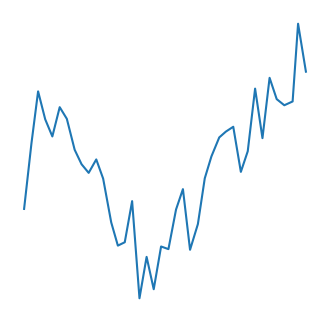

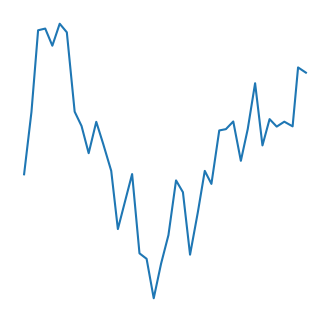

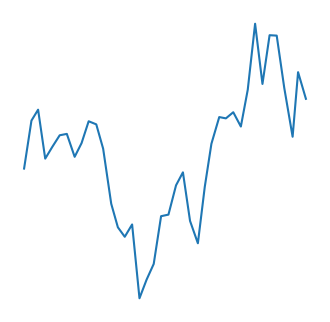

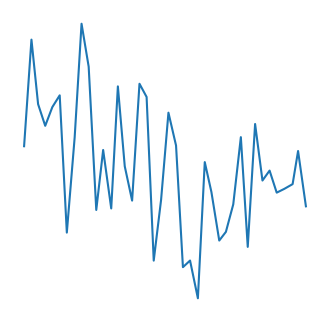

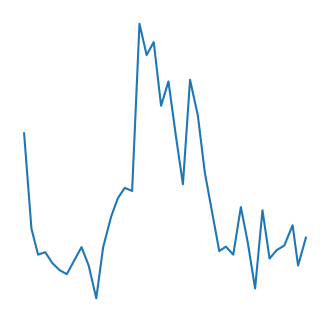

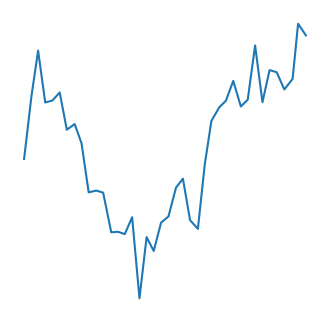

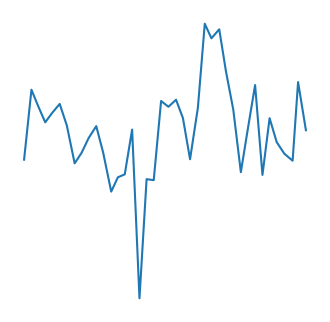

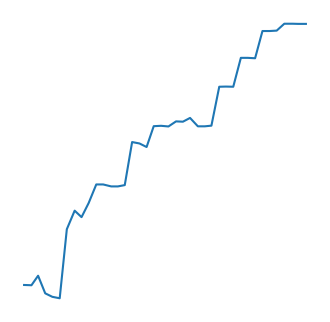

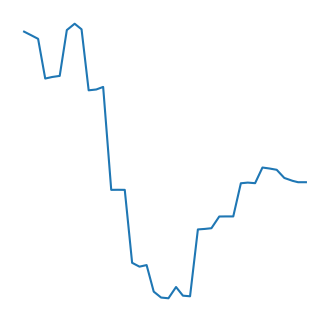

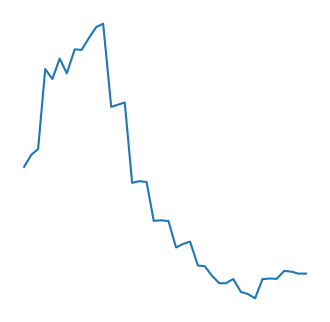

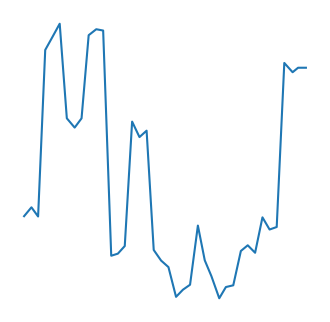

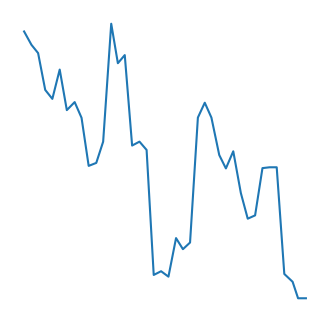

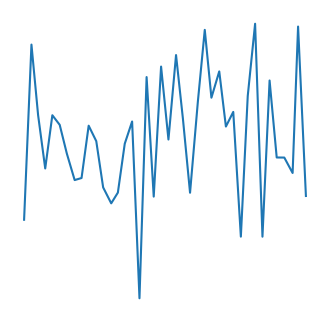

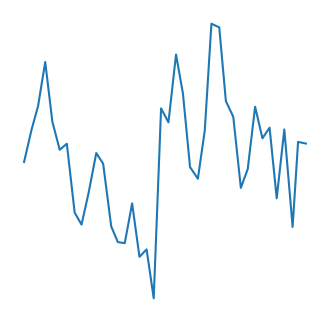

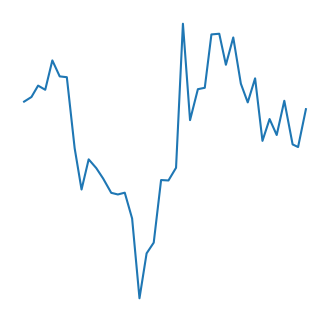

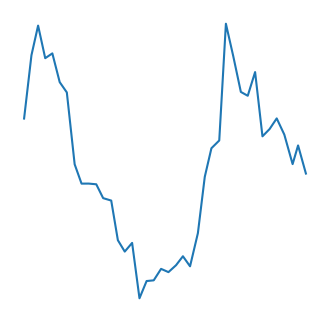

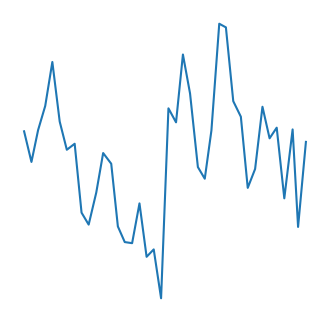

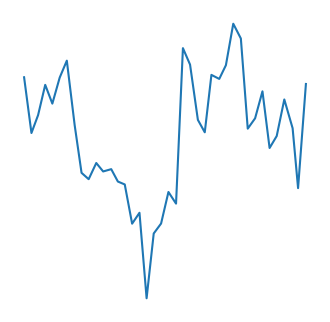

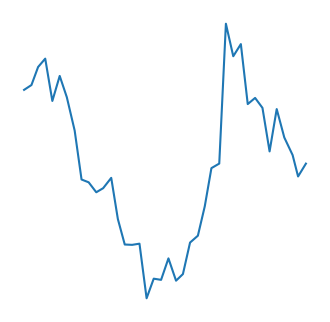

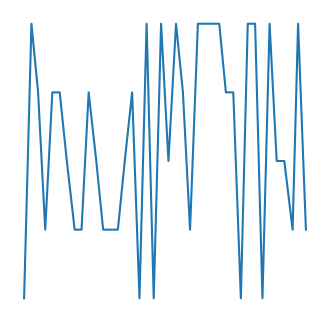

In [150]:
from pathlib import Path

for count,attribute in enumerate(predictors_columns):
    plt.figure(figsize=(4, 4), dpi=100)
    plt.plot(AAPL_data.Date,AAPL_data[attribute])
    frame1 = plt.gca()
    frame1.axis('off')
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    
    direc = "{}/".format(last_date) #Make directory to contain image of time series for a stock and for a specific time-window
    Path(direc).mkdir(parents=True, exist_ok=True)
    figname = "{}/{}_Attribute_{}_{}.png".format(last_date,last_date,count,attribute)
    plt.savefig(figname, dpi=100)

[]

<Figure size 400x400 with 0 Axes>

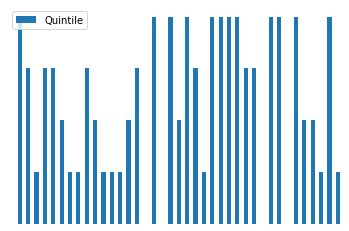

In [155]:
plt.figure(figsize=(4, 4), dpi=100)
AAPL_data.plot("Date","Quintile",kind = "bar")
frame1 = plt.gca()
frame1.axis('off')
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])

In [157]:
AAPL_data.Quintile.isna().sum()

0